## Notebook for training model from scratch

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch import softmax
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel, EvalPrediction, Trainer, TrainingArguments

### Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HateClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, num_heads=12, hidden_dim=3072, num_layers=12, max_len=128, num_labels=2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim, 
            dropout=0.2,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(embed_dim, num_labels)
        
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)
        x = x + self.pos_embedding[:, :x.size(1), :]
        
        if attention_mask is not None:
            attn_mask = ~attention_mask.bool() 
        else:
            attn_mask = None
        
        x = self.transformer_encoder(x, src_key_padding_mask=attn_mask)
        
        cls_token = x[:, 0, :]
        
        cls_token = self.dropout(cls_token)
        logits = self.classifier(cls_token)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return {"loss": loss, "logits": logits}


### Prepare data

In [3]:
df = pd.read_csv("data/train.csv")
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df["Class"])

In [4]:
class HateDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [5]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

train_dataset = HateDataset(train_df["Text"].tolist(), train_df["Class"].tolist(), tokenizer)
val_dataset = HateDataset(val_df["Text"].tolist(), val_df["Class"].tolist(), tokenizer)

### Training 

In [6]:
import numpy as np

def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids
    logits = eval_pred.predictions 

    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    proba = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    y_pred_proba = proba[:, 1]

    y_pred = (y_pred_proba >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

In [7]:
def train(
        model,
        train_dataset,
        val_dataset,
        output_dir="model_output",
        epochs=3,
        batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        save_steps=50,
        seed=42
):
    torch.manual_seed(seed)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        eval_strategy="steps",
        logging_steps=logging_steps,
        save_steps=save_steps,
        eval_steps=save_steps,         
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=seed,
        fp16=torch.cuda.is_available()
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()
    print("Final evaluation metrics:", metrics)
    return trainer, trainer.model

In [11]:
def plot_training(trainer):
    df = pd.DataFrame(trainer.state.log_history)
    df_train = df.dropna(subset=["loss"])
    df_eval = df.dropna(subset=["eval_loss"])

    plt.figure(figsize=(10, 5))

    plt.plot(df_train["step"], df_train["loss"], label="Training Loss")
    plt.plot(df_eval["step"], df_eval["eval_loss"], label="Validation Loss")

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_metrics(trainer):
    df = pd.DataFrame(trainer.state.log_history)
    metrics = ["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        df_metric = df.dropna(subset=[metric])
        axes[i].plot(df_metric["step"], df_metric[metric], marker='o')
        axes[i].set_title(metric)
        axes[i].set_xlabel("Step")
        axes[i].set_ylabel(metric)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()


In [13]:
device = torch.device("cuda")
model = HateClassifier(vocab_size=tokenizer.vocab_size)
model.to(device)

trainer, trained_model = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    output_dir="./hate_model_scratch",
    epochs=3,
    batch_size=64,
    learning_rate=2e-5,
    logging_steps=20,
)

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.674100,0.604819,0.678241,0.735043,0.557407,0.634018
100,0.641500,0.575988,0.691204,0.851789,0.462963,0.599880
150,0.554500,0.665485,0.619444,0.573968,0.926852,0.708924
200,0.555100,0.513476,0.738426,0.738647,0.737963,0.738305
250,0.575700,0.528653,0.733333,0.691199,0.843519,0.759800
300,0.537400,0.470495,0.777315,0.789932,0.755556,0.772362
350,0.555900,0.477556,0.762963,0.762477,0.763889,0.763182
400,0.466300,0.456230,0.775000,0.772477,0.779630,0.776037
450,0.468600,0.446365,0.784259,0.846501,0.694444,0.762970
500,0.486100,0.474903,0.769444,0.742500,0.825000,0.781579


Final evaluation metrics: {'eval_loss': 0.43014588952064514, 'eval_accuracy': 0.7972222222222223, 'eval_precision': 0.7961254612546126, 'eval_recall': 0.799074074074074, 'eval_f1': 0.7975970425138632, 'eval_runtime': 1.3161, 'eval_samples_per_second': 1641.154, 'eval_steps_per_second': 25.833, 'epoch': 3.0}


In [14]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
df_logs.to_csv("scratch_training_logs.csv", index=False)

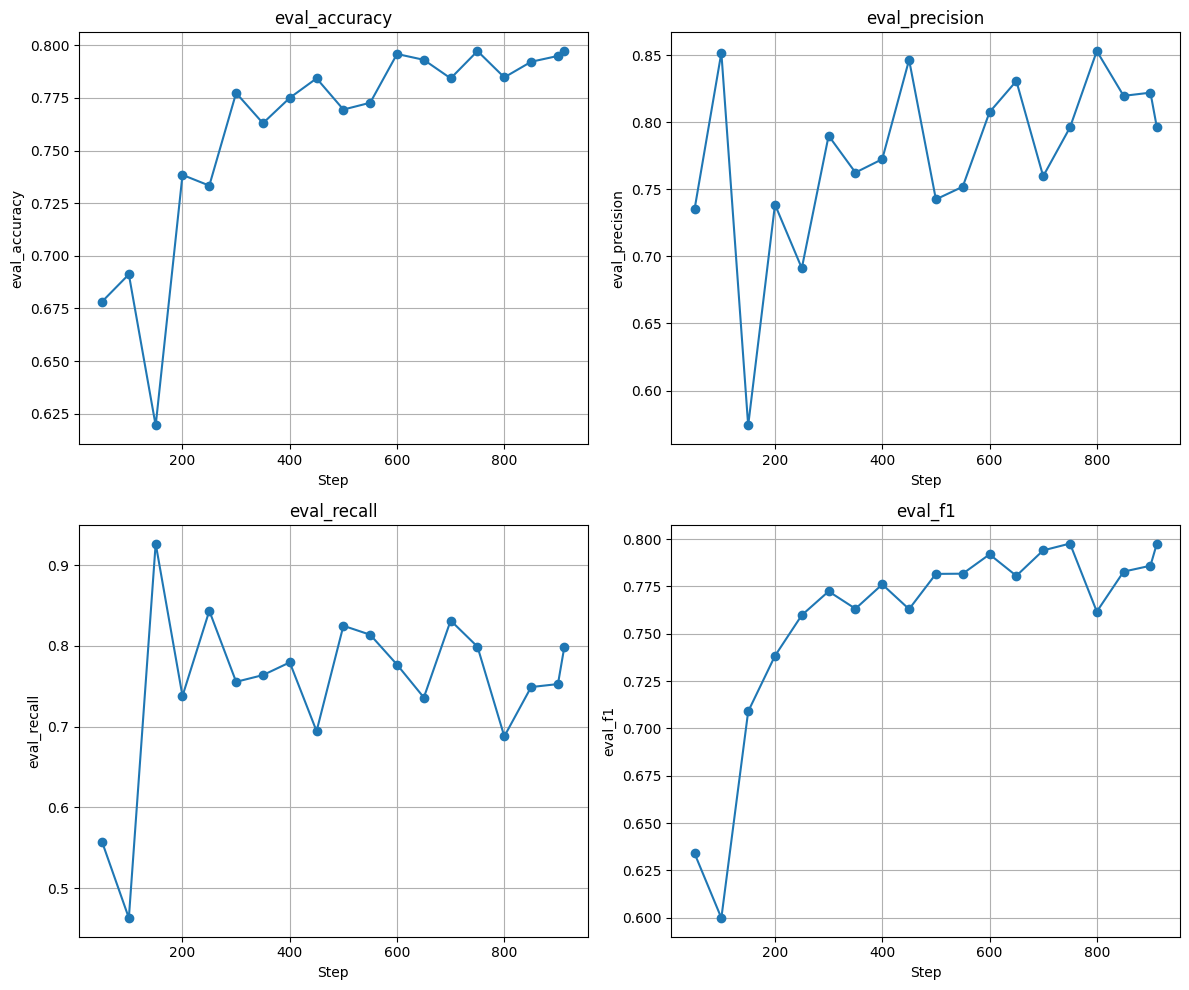

In [15]:
plot_metrics(trainer)

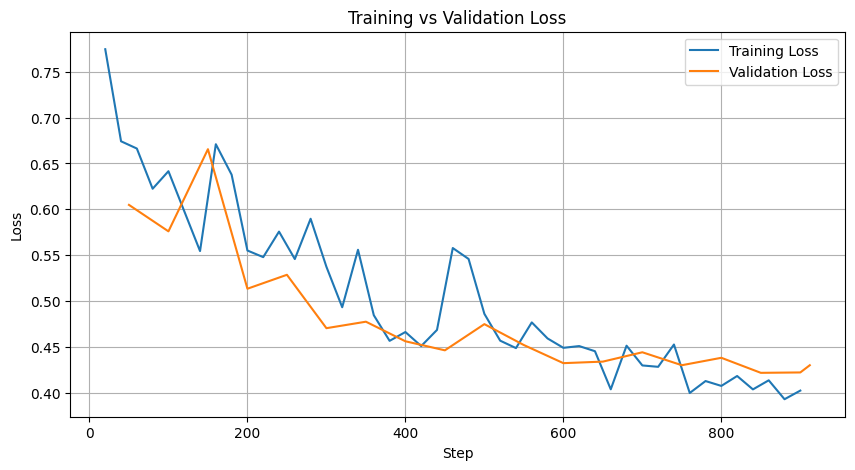

In [16]:
plot_training(trainer)